In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib import cm

from sklearn.linear_model import Ridge, LinearRegression, Lasso
import sklearn.ensemble as skens
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold
import sklearn.metrics as metrics

%matplotlib inline

In [2]:
data = pd.read_csv('diamonds.csv',index_col=0)
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [13]:
data.describe()

,carat,depth,table,price,x,y,z,log_price
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734,7.786768
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699,1.014649
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000,5.786897
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000,6.856462
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000,7.783641
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000,8.580027
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000,9.842835


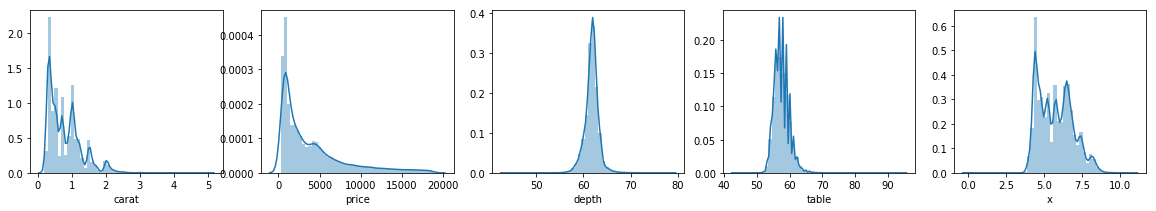

In [30]:
# display the distributions of all the numerical data
data['log_price'] = np.log(data.price)

data_test = [data.carat, data.depth, data.table, data.price, data.x]
plt.figure(figsize=(20,3))
for i in xrange(len(data_test)):
    plt.subplot(1,5,i+1)
    sns.distplot(data_test[i])
plt.show()

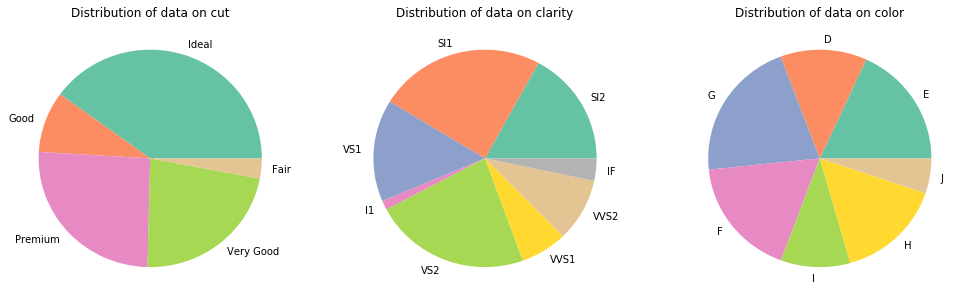

In [12]:
# display the distributions of the categorical data
c = ['cut','clarity','color']

plt.figure(figsize=(17,5))
for i in range(len(c)):
    plt.subplot(1,3,i+1)
    data_rep = data[c[i]].value_counts().to_dict()
    plt.pie([float(v) for v in data_rep.values()], labels=[k for k in data_rep.keys()], autopct=None, colors=cm.Set2(np.arange(float(len(data_rep.keys())))/len(data_rep.keys())))
    plt.title('Distribution of data on {}'.format(c[i]))

seems like carat and price are right skewed; we can take the log to sort of normalize

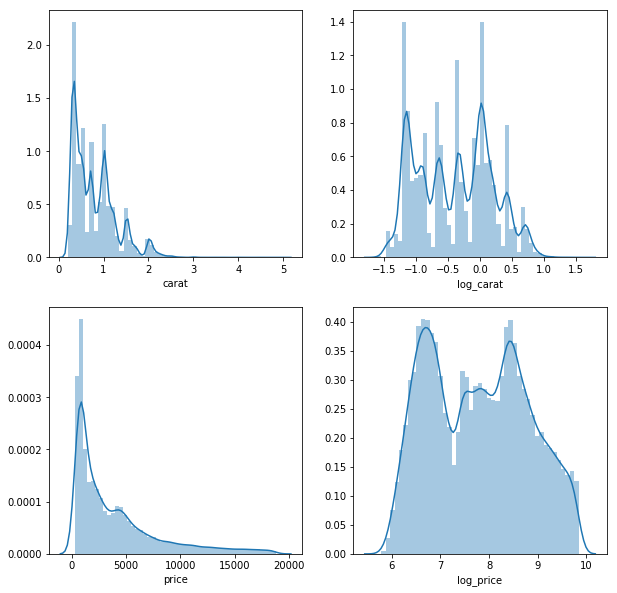

In [32]:
data['log_price'] = np.log(data.price)
data['log_carat'] = np.log(data.carat)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1);
sns.distplot(data.carat);
plt.subplot(2,2,2);
sns.distplot(data.log_carat);
plt.subplot(2,2,3);
sns.distplot(data.price);
plt.subplot(2,2,4);
sns.distplot(data.log_price);

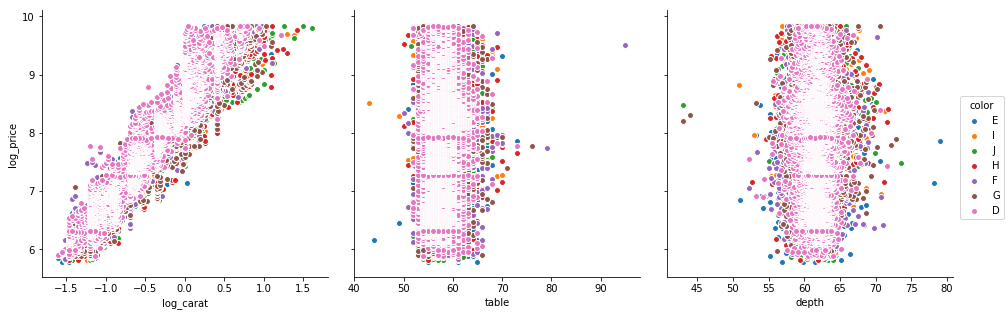

In [38]:
p = ['log_carat','table','depth']
sns.pairplot(x_vars=p, y_vars=['log_price'], data=data, hue='color', size=4.5);

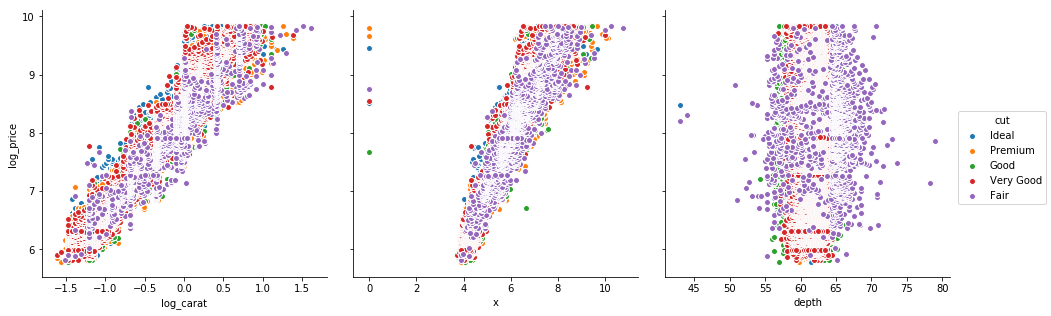

In [39]:
sns.pairplot(x_vars=['log_carat','x','depth'], y_vars=['log_price'], data=data, hue='cut', size=4.5);

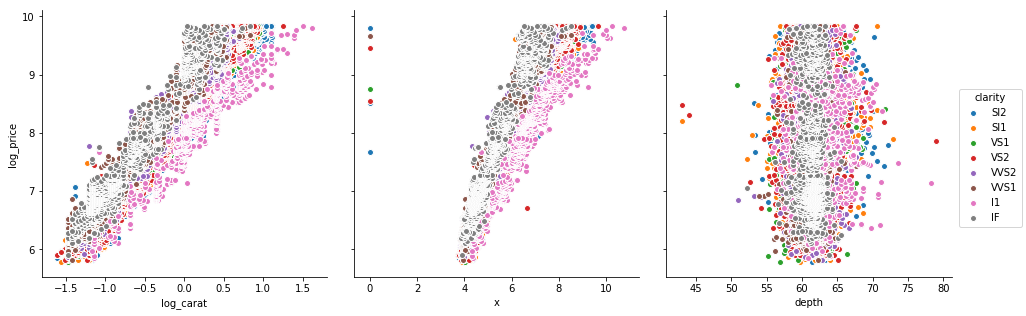

In [40]:
sns.pairplot(x_vars=['log_carat','x','depth'], y_vars=['log_price'], data=data, hue='clarity', size=4.5);

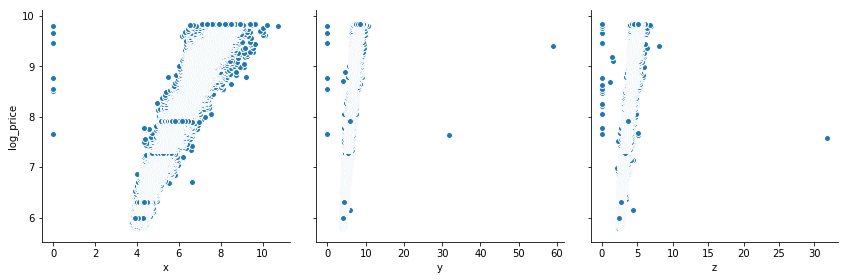

In [41]:
xyz = ['x','y','z']
sns.pairplot(x_vars=xyz, y_vars=['log_price'], data=data, size=4.0);

In [42]:
data.color = data.color.map({'J':0,'I':1,'H':2,'G':3,'F':4,'E':5,'D':6})
data.clarity = data.clarity.map({'I1':0, 'SI2':1, 'SI1':2, 'VS2':3, 'VS1':4, 'VVS2':5, 'VVS1':6, 'IF':7})
data.cut = data.cut.map({'Fair':0,'Good':1,'Very Good':2,'Premium':3,'Ideal':4})

In [43]:
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,log_price,log_carat
1,0.23,4,5,1,61.5,55.0,326,3.95,3.98,2.43,5.786897,-1.469676
2,0.21,3,5,2,59.8,61.0,326,3.89,3.84,2.31,5.786897,-1.560648
3,0.23,1,5,4,56.9,65.0,327,4.05,4.07,2.31,5.789960,-1.469676
4,0.29,3,1,3,62.4,58.0,334,4.20,4.23,2.63,5.811141,-1.237874
5,0.31,1,0,1,63.3,58.0,335,4.34,4.35,2.75,5.814131,-1.171183


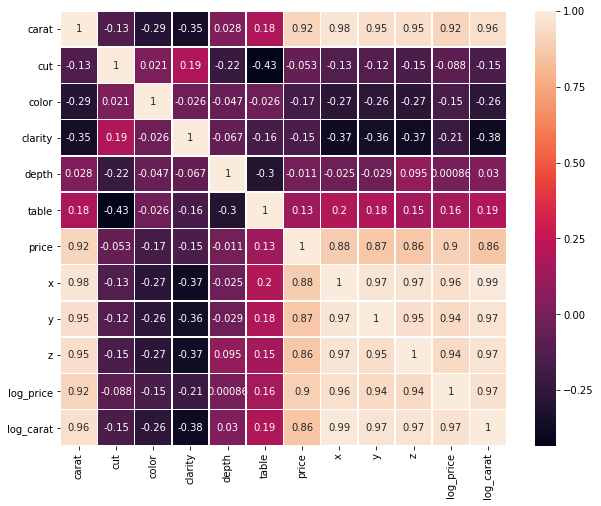

In [44]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(),annot=True,linewidths=0.5);

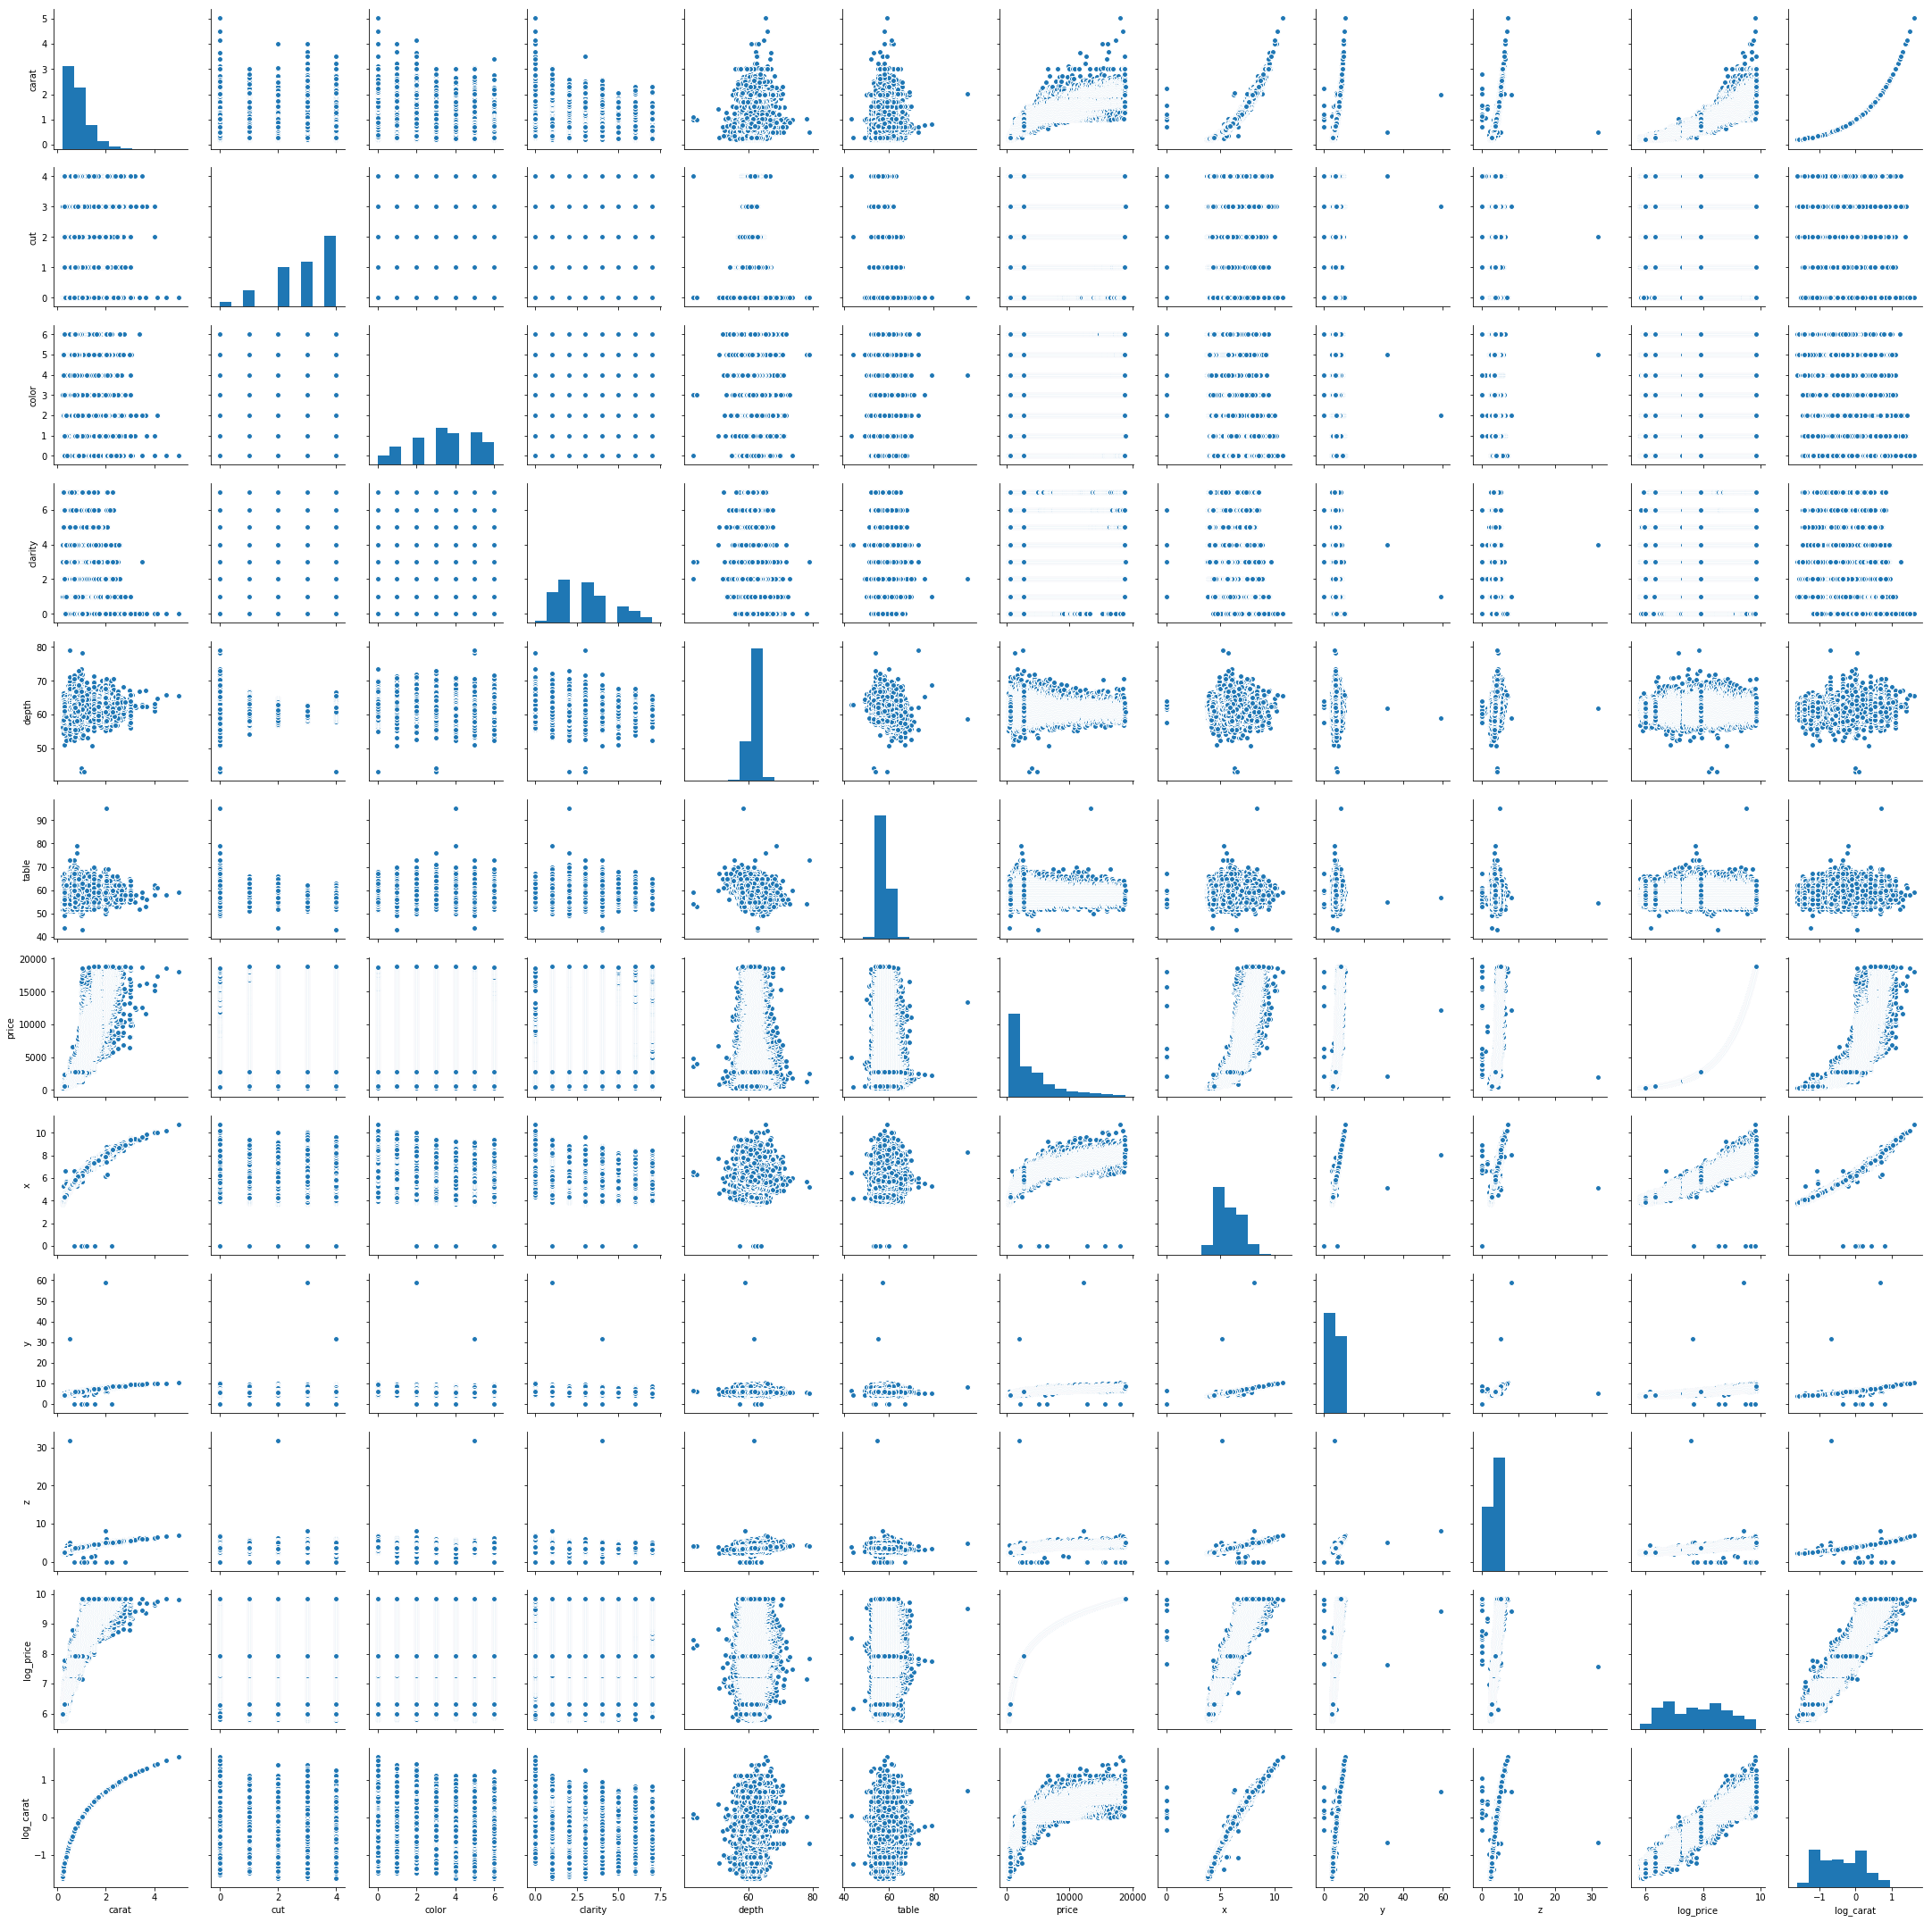

In [45]:
sns.pairplot(data);

In [56]:
data.drop('price', axis=1, inplace=True)
data.drop('carat', axis=1, inplace=True)

In [63]:
print type(data)

<class 'pandas.core.frame.DataFrame'>


In [57]:
### Model Building ###

def inv_log(preds):
    # apply inverse log function
    transformed_preds = []
    for val in preds:
        transformed_preds.append(np.round(math.exp(val), 2))
    return np.array(transformed_preds)
    

X = data.iloc[:,:-1]
y = data.log_price

X_train, X_60, y_train, y_60 = train_test_split(X,y, test_size=0.6, random_state=2)

print('Data split 50/50...\nShape of training: {}\nShape of Other: {}\n---'.format(X_train.shape, X_60.shape))

X_valid, X_test, y_valid, y_test = train_test_split(X_60, y_60, test_size=0.5, random_state=2)

print("Further split 'Other' into 50/50 validation and test sets...\nShape of Validation Set: {}\nShape of Test Set: {}".format(X_valid.shape, X_test.shape))

Data split 50/50...
Shape of training: (21576, 9)
Shape of Other: (32364, 9)
---
Further split 'Other' into 50/50 validation and test sets...
Shape of Validation Set: (16182, 9)
Shape of Test Set: (16182, 9)


In [59]:
gb = skens.GradientBoostingRegressor().fit(X_train, y_train)
y_pred_train = gb.predict(X_train)
y_pred = gb.predict(X_valid)
print('R Squared:\ntraining -- {}\nvalidation -- {}'.format(metrics.r2_score(inv_log(y_train), inv_log(y_pred_train)), metrics.r2_score(inv_log(y_valid), inv_log(y_pred))))
error = inv_log(y_valid) - inv_log(y_pred)
print('Average Price Error: {}'.format(error.mean()))

y_pred_test = gb.predict(X_test)
print metrics.r2_score(inv_log(y_test), inv_log(y_pred_test))


R Squared:
training -- 0.999901511158
validation -- 0.999896530701
Average Price Error: -0.417194413546
0.999897199271


In [62]:
for x in zip(inv_log(y_test), inv_log(y_pred_test)):
    print x

(2020.0, 2021.9300000000001)
(5488.0, 5482.96)
(1841.0, 1838.8)
(2137.0, 2114.6199999999999)
(8465.0, 8440.8299999999999)
(3624.0, 3614.3200000000002)
(827.0, 826.14999999999998)
(2370.0, 2364.04)
(887.0, 890.03999999999996)
(1066.0, 1064.48)
(3710.0, 3706.98)
(6521.0, 6565.8199999999997)
(4827.0, 4781.46)
(827.0, 826.14999999999998)
(5746.0, 5816.3900000000003)
(9932.0, 9991.2999999999993)
(9146.0, 8980.1800000000003)
(13587.0, 13752.889999999999)
(1286.0, 1289.0)
(628.0, 624.88)
(7764.0, 7810.8999999999996)
(13182.0, 13287.24)
(4189.0, 4186.0100000000002)
(576.0, 573.69000000000005)
(1087.0, 1104.1600000000001)
(1017.0, 1017.17)
(811.0, 818.11000000000001)
(1655.0, 1656.0699999999999)
(588.0, 590.87)
(1239.0, 1242.2)
(2192.0, 2167.8499999999999)
(5154.0, 5169.2200000000003)
(1883.0, 1888.0999999999999)
(4924.0, 4924.8999999999996)
(4209.0, 4199.2600000000002)
(2066.0, 2058.8800000000001)
(10662.0, 10857.6)
(3167.0, 3179.5900000000001)
(6468.0, 6561.0699999999997)
(776.0, 767.23000000

(10821.0, 10878.450000000001)
(4440.0, 4475.3199999999997)
(561.0, 556.51999999999998)
(6963.0, 6883.5799999999999)
(7306.0, 7289.9200000000001)
(4208.0, 4199.2600000000002)
(2829.0, 2815.48)
(7409.0, 7289.9200000000001)
(2881.0, 2896.6399999999999)
(7279.0, 7275.9499999999998)
(2665.0, 2643.6500000000001)
(7778.0, 7810.8999999999996)
(2239.0, 2233.9400000000001)
(1323.0, 1321.1400000000001)
(879.0, 870.78999999999996)
(1263.0, 1269.4100000000001)
(6169.0, 6195.5799999999999)
(1875.0, 1888.0999999999999)
(442.0, 440.47000000000003)
(3816.0, 3800.7600000000002)
(561.0, 556.51999999999998)
(5556.0, 5488.1099999999997)
(552.0, 553.75)
(2203.0, 2233.25)
(3482.0, 3464.8600000000001)
(2548.0, 2520.79)
(6888.0, 6883.5799999999999)
(1131.0, 1127.8900000000001)
(5988.0, 6064.1400000000003)
(871.0, 870.22000000000003)
(13666.0, 13752.889999999999)
(545.0, 543.77999999999997)
(10960.0, 10917.75)
(2525.0, 2517.3299999999999)
(746.0, 735.09000000000003)
(621.0, 618.60000000000002)
(7278.0, 7275.949

(886.0, 889.95000000000005)
(9348.0, 9366.5)
(2070.0, 2058.8800000000001)
(432.0, 432.25)
(9297.0, 9366.5)
(1084.0, 1065.76)
(586.0, 590.75999999999999)
(5544.0, 5488.1099999999997)
(760.0, 762.62)
(7207.0, 7176.2299999999996)
(5248.0, 5253.4499999999998)
(1999.0, 2002.05)
(7852.0, 7823.8900000000003)
(4830.0, 4781.46)
(4521.0, 4512.96)
(18394.0, 18374.150000000001)
(981.0, 978.09000000000003)
(497.0, 501.16000000000003)
(4678.0, 4721.71)
(2873.0, 2896.6399999999999)
(1376.0, 1388.1500000000001)
(3168.0, 3179.5900000000001)
(2147.0, 2159.79)
(4657.0, 4721.71)
(552.0, 553.86000000000001)
(1906.0, 1903.4000000000001)
(6754.0, 6795.6300000000001)
(1308.0, 1315.51)
(838.0, 836.25)
(2824.0, 2815.48)
(613.0, 618.72000000000003)
(4514.0, 4512.96)
(3622.0, 3614.3200000000002)
(1451.0, 1449.7)
(407.0, 408.16000000000003)
(707.0, 707.45000000000005)
(5088.0, 5065.8500000000004)
(15038.0, 14973.34)
(675.0, 675.72000000000003)
(1985.0, 2002.05)
(13929.0, 13860.09)
(2916.0, 2910.79)
(16073.0, 16144

(1983.0, 1967.8399999999999)
(720.0, 719.21000000000004)
(999.0, 1012.9)
(4372.0, 4317.6199999999999)
(1838.0, 1838.24)
(1922.0, 1903.4000000000001)
(2575.0, 2610.8000000000002)
(1243.0, 1243.0599999999999)
(9071.0, 8980.1800000000003)
(3457.0, 3460.7800000000002)
(449.0, 448.38)
(643.0, 648.57000000000005)
(965.0, 962.88999999999999)
(1163.0, 1168.04)
(772.0, 767.30999999999995)
(12200.0, 12285.18)
(1654.0, 1653.77)
(3830.0, 3800.7600000000002)
(3874.0, 3810.8400000000001)
(854.0, 851.65999999999997)
(2304.0, 2342.9699999999998)
(1151.0, 1168.04)
(1764.0, 1738.49)
(1084.0, 1065.76)
(5340.0, 5346.0600000000004)
(15887.0, 15873.42)
(2176.0, 2167.8499999999999)
(2563.0, 2520.79)
(4273.0, 4266.4799999999996)
(5604.0, 5668.3400000000001)
(767.0, 766.67999999999995)
(6023.0, 6076.8699999999999)
(1868.0, 1888.0999999999999)
(2238.0, 2233.9400000000001)
(1071.0, 1065.76)
(4646.0, 4584.5)
(9586.0, 9515.2000000000007)
(854.0, 851.65999999999997)
(970.0, 963.34000000000003)
(526.0, 526.110000000

(5351.0, 5346.0600000000004)
(13355.0, 13330.18)
(4714.0, 4725.2700000000004)
(6732.0, 6795.6300000000001)
(4101.0, 4138.3400000000001)
(1547.0, 1527.4100000000001)
(10038.0, 10014.690000000001)
(408.0, 408.16000000000003)
(2982.0, 2974.8499999999999)
(742.0, 734.95000000000005)
(2873.0, 2896.6399999999999)
(738.0, 734.20000000000005)
(1209.0, 1203.03)
(1725.0, 1728.8099999999999)
(5242.0, 5253.4499999999998)
(7106.0, 7167.0)
(2052.0, 2058.8800000000001)
(7291.0, 7289.9200000000001)
(3262.0, 3258.71)
(828.0, 826.05999999999995)
(15959.0, 15882.209999999999)
(956.0, 962.10000000000002)
(13278.0, 13287.24)
(1223.0, 1241.0999999999999)
(911.0, 914.11000000000001)
(6108.0, 6104.9499999999998)
(678.0, 677.07000000000005)
(9292.0, 9366.5)
(14709.0, 14852.57)
(492.0, 490.20999999999998)
(863.0, 865.15999999999997)
(2571.0, 2610.8000000000002)
(3569.0, 3614.3200000000002)
(17606.0, 17609.23)
(1290.0, 1288.6099999999999)
(540.0, 543.77999999999997)
(2250.0, 2254.4400000000001)
(14430.0, 14483.0

(764.0, 762.78999999999996)
(14294.0, 14274.93)
(514.0, 511.85000000000002)
(1607.0, 1600.3699999999999)
(1250.0, 1245.1900000000001)
(7506.0, 7535.8599999999997)
(8315.0, 8284.6599999999999)
(1956.0, 1960.1600000000001)
(1240.0, 1242.5799999999999)
(10688.0, 10849.74)
(605.0, 605.26999999999998)
(863.0, 865.25)
(15874.0, 15855.629999999999)
(1764.0, 1739.02)
(649.0, 648.88999999999999)
(12841.0, 12813.34)
(1875.0, 1887.52)
(4626.0, 4584.5)
(4476.0, 4480.1099999999997)
(1549.0, 1526.9400000000001)
(5302.0, 5304.7399999999998)
(666.0, 672.90999999999997)
(11942.0, 11798.57)
(7597.0, 7581.3900000000003)
(5858.0, 5822.2299999999996)
(6934.0, 6883.5799999999999)
(1364.0, 1346.1099999999999)
(5773.0, 5816.3900000000003)
(3471.0, 3464.8600000000001)
(648.0, 648.44000000000005)
(1026.0, 1024.51)
(6509.0, 6561.0699999999997)
(11269.0, 11262.02)
(2952.0, 2972.23)
(3528.0, 3464.8600000000001)
(603.0, 604.52999999999997)
(2856.0, 2821.1399999999999)
(2934.0, 2912.3000000000002)
(706.0, 707.450000

(3424.0, 3430.0300000000002)
(1659.0, 1656.0699999999999)
(5013.0, 5065.8500000000004)
(1356.0, 1344.51)
(3519.0, 3464.8600000000001)
(4186.0, 4186.0100000000002)
(2555.0, 2520.79)
(1772.0, 1796.6700000000001)
(11015.0, 10935.51)
(3056.0, 3050.6500000000001)
(4082.0, 4053.73)
(358.0, 358.29000000000002)
(7588.0, 7581.3900000000003)
(1125.0, 1126.1900000000001)
(438.0, 440.47000000000003)
(13786.0, 13769.129999999999)
(5290.0, 5289.6099999999997)
(2080.0, 2083.6799999999998)
(645.0, 648.44000000000005)
(1183.0, 1168.5699999999999)
(1088.0, 1104.1600000000001)
(2056.0, 2058.8800000000001)
(2179.0, 2167.8499999999999)
(5571.0, 5488.1099999999997)
(2047.0, 2044.1700000000001)
(975.0, 978.09000000000003)
(1041.0, 1029.4200000000001)
(1743.0, 1739.02)
(10427.0, 10359.629999999999)
(829.0, 826.14999999999998)
(1004.0, 1012.9)
(1043.0, 1029.4200000000001)
(1357.0, 1344.51)
(521.0, 525.91999999999996)
(942.0, 943.0)
(9242.0, 9356.0300000000007)
(6480.0, 6561.0699999999997)
(12047.0, 12287.03000

(6099.0, 6087.0500000000002)
(2672.0, 2643.6500000000001)
(1760.0, 1738.49)
(5551.0, 5488.1099999999997)
(2044.0, 2044.1700000000001)
(1287.0, 1288.6099999999999)
(2475.0, 2475.8299999999999)
(1622.0, 1631.9200000000001)
(1069.0, 1064.48)
(886.0, 889.95000000000005)
(853.0, 851.57000000000005)
(16206.0, 16159.98)
(6492.0, 6561.0699999999997)
(2744.0, 2734.27)
(795.0, 791.83000000000004)
(732.0, 733.79999999999995)
(1829.0, 1838.8)
(905.0, 903.98000000000002)
(3465.0, 3464.8600000000001)
(3584.0, 3614.3200000000002)
(16519.0, 16529.43)
(612.0, 605.71000000000004)
(1063.0, 1063.6199999999999)
(5005.0, 4939.8900000000003)
(645.0, 648.44000000000005)
(6303.0, 6265.75)
(1649.0, 1653.77)
(765.0, 765.36000000000001)
(13942.0, 13855.969999999999)
(5240.0, 5253.4499999999998)
(1183.0, 1168.5699999999999)
(7959.0, 8043.9300000000003)
(632.0, 625.0)
(2954.0, 2972.23)
(4423.0, 4475.3199999999997)
(1922.0, 1903.4000000000001)
(1234.0, 1242.2)
(2006.0, 2003.6500000000001)
(2904.0, 2902.1199999999999

(4157.0, 4156.5500000000002)
(1326.0, 1321.1400000000001)
(907.0, 903.98000000000002)
(1013.0, 1014.09)
(539.0, 543.88)
(907.0, 904.27999999999997)
(1689.0, 1701.21)
(3294.0, 3258.71)
(1629.0, 1631.4200000000001)
(438.0, 440.47000000000003)
(6125.0, 6104.9499999999998)
(1382.0, 1387.72)
(5124.0, 5169.2200000000003)
(2307.0, 2342.9699999999998)
(1013.0, 1013.99)
(5618.0, 5668.3400000000001)
(10058.0, 10039.6)
(3169.0, 3179.5900000000001)
(12737.0, 12757.870000000001)
(6532.0, 6571.4300000000003)
(7741.0, 7810.8999999999996)
(8227.0, 8276.9400000000005)
(7909.0, 7823.8900000000003)
(4666.0, 4721.71)
(4338.0, 4311.7700000000004)
(872.0, 870.22000000000003)
(544.0, 543.77999999999997)
(5412.0, 5395.7399999999998)
(2164.0, 2167.8499999999999)
(673.0, 673.38999999999999)
(12260.0, 12294.08)
(611.0, 605.71000000000004)
(1073.0, 1065.76)
(1601.0, 1600.3699999999999)
(1197.0, 1203.1500000000001)
(596.0, 596.44000000000005)
(2042.0, 2044.1700000000001)
(700.0, 704.83000000000004)
(1094.0, 1104.1

In [65]:
data.describe()

,cut,color,clarity,depth,table,x,y,z,log_price,log_carat
1,4,5,1,61.5,55.0,3.95,3.98,2.43,5.786897,-1.469676
2,3,5,2,59.8,61.0,3.89,3.84,2.31,5.786897,-1.560648
3,1,5,4,56.9,65.0,4.05,4.07,2.31,5.789960,-1.469676
4,3,1,3,62.4,58.0,4.20,4.23,2.63,5.811141,-1.237874
5,1,0,1,63.3,58.0,4.34,4.35,2.75,5.814131,-1.171183
6,2,0,5,62.8,57.0,3.94,3.96,2.48,5.817111,-1.427116
7,2,1,6,62.3,57.0,3.95,3.98,2.47,5.817111,-1.427116
8,2,2,2,61.9,55.0,4.07,4.11,2.53,5.820083,-1.347074
9,0,5,3,65.1,61.0,3.87,3.78,2.49,5.820083,-1.514128
10,2,2,4,59.4,61.0,4.00,4.05,2.39,5.823046,-1.469676
